In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#Business Problem understanding

**Context**

California, salah satu negara bagian dengan populasi terbesar di AS, mengalami perubahan besar dalam hal harga perumahan. Pertumbuhan ekonomi, populasi yang terus meningkat, dan akses ke berbagai layanan serta peluang kerja telah membuat permintaan perumahan meningkat tajam. Harga rumah di wilayah tersebut sangat bervariasi tergantung pada berbagai faktor, seperti lokasi geografis, usia bangunan, kedekatan dengan laut, serta tingkat pendapatan rumah tangga. Memahami faktor-faktor yang memengaruhi harga rumah menjadi penting bagi pembeli, investor, dan perusahaan properti agar dapat mengambil keputusan yang lebih baik. Dengan analisis yang tepat, kita dapat memprediksi nilai median rumah dan memberikan wawasan berharga bagi pihak terkait.

Referensi:

https://jordanlink.com/home-sales-in-california#:~:text=Current%20Trends%20Impacting%20Home%20Sales%20in%20California&text=With%20a%2024.8%25%20drop%20in,regional%20differences%20are%20significant%20factors.

https://www.anderson.ucla.edu/news-and-events/press-releases/june-2024-economic-forecast


**Problem Statement**

Bagaimana memprediksi nilai median rumah di California berdasarkan faktor-faktor seperti lokasi geografis, jumlah kamar, jumlah rumah tangga, pendapatan median, serta kedekatan rumah dengan laut? Apa saja faktor yang paling berpengaruh dalam menentukan harga rumah di wilayah tersebut?

**Goals**

Tujuan dari pemodelan ini adalah untuk memprediksi nilai median rumah berdasarkan fitur-fitur yang ada di seputaran daerah California.

**Analytical Approach**

Menganalisis data untuk dapat menemukan pola dari fitur-fitur yang ada, yang membedakan satu properti dengan yang lainnya.

Selanjutnya, kita akan membangun suatu model regresi yang akan membantu perusahaan untuk dapat menyediakan 'tool' prediksi harga jual rumah yang baru di California, yang mana akan berguna untuk pembeli dan investor terkait faktor-faktor yang mempengaruhi harga rumah.

**Metric Evaluation**

Dalam mengevaluasi model yang dibuat, metric yang akan digunakan adalah:

1. RMSE : Nilai rataan akar kuadrat dari error
2. MAE : Rataan nilai absolut dari error
3. MAPE : Rataan persentase error yang dihasilkan oleh model regresi
4. R-squared : Untuk mengetahui seberapa baik model dapat merepresentasikan varians keseluruhan data.

#Data Understanding

In [3]:
# Load dataset
df = pd.read_csv('data_california_house.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


## Penjelasan setiap variable (Data Dictionary)

|Nama Variabel | Tipe Data | Penjelasan |
|---- | ---- | ---- |
| longitude | float | Lokasi geografis rumah berdasarkan koordinat bujur (longitude), di mana negatif menunjukkan posisi barat. |
| latitude | float | Lokasi geografis rumah berdasarkan koordinat lintang (latitude), di mana positif menunjukkan posisi utara. |
| housing_median_age | float | Usia median rumah di daerah tertentu, menunjukkan umur bangunan dalam tahun |
| total_rooms | float | Jumlah total kamar di semua rumah yang ada di wilayah tersebut |
| total_bedrooms | float | Jumlah total kamar tidur di semua rumah yang ada di wilayah tersebut |
| population | float | Jumlah populasi di wilayah tertentu yang menunjukkan total penduduk yang tinggal di daerah tersebut. |
| households | float | Jumlah rumah tangga di wilayah tersebut |
| median_income | float | Pendapatan median per rumah tangga di daerah tersebut |
| ocean_proximity  | object | Kedekatan rumah dengan laut yang dikategorikan menjadi beberapa kategori |
| median_house_value | float | Nilai median rumah di daerah tersebut|

In [4]:
print(f'Jumlah baris dan kolom di dataset df adalah {df.shape}')
df.info()

Jumlah baris dan kolom di dataset df adalah (14448, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   housing_median_age  14448 non-null  float64
 3   total_rooms         14448 non-null  float64
 4   total_bedrooms      14311 non-null  float64
 5   population          14448 non-null  float64
 6   households          14448 non-null  float64
 7   median_income       14448 non-null  float64
 8   ocean_proximity     14448 non-null  object 
 9   median_house_value  14448 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.1+ MB


##Missing Values

In [5]:
# Jumlah data kosong (NaN) untuk setiap variable
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,137
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


In [6]:
# Agar lebih "cantik" dibuat dataframe
missing = pd.DataFrame({'jumlah':df.isnull().sum().sort_values(ascending = False)})
missing

,jumlah
total_bedrooms,137
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


In [7]:
total_baris_data = len(df)
missing['persentase %'] = round((missing['jumlah']/total_baris_data)*100,2)
missing

,jumlah,persentase %
total_bedrooms,137,0.95
longitude,0,0.00
latitude,0,0.00
housing_median_age,0,0.00
total_rooms,0,0.00
population,0,0.00
households,0,0.00
median_income,0,0.00
ocean_proximity,0,0.00
median_house_value,0,0.00


<Axes: >

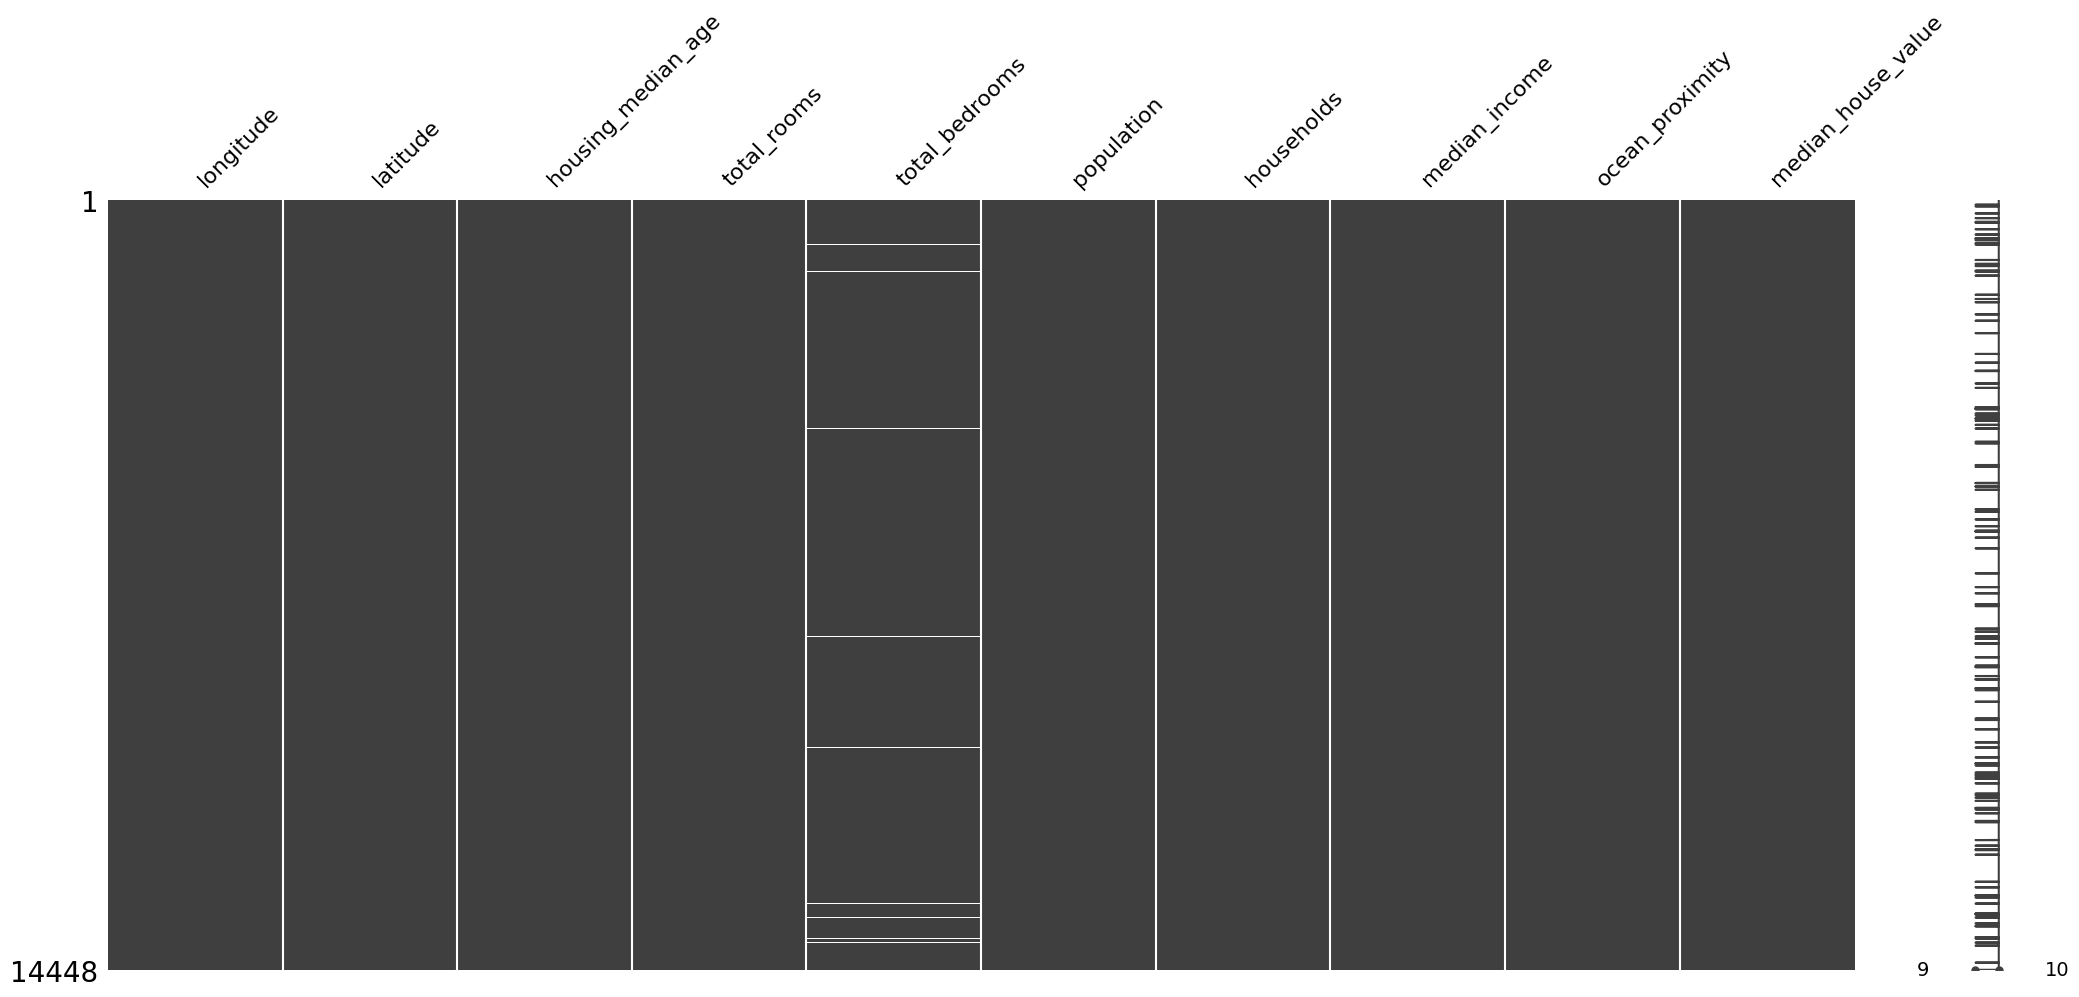

In [8]:
import missingno

# Hubungan antar missing values secara visualisasi
missingno.matrix(df)

Pada data california house ditemukan missing value pada kolom total_bedrooms dengan jumlah yang sangat kecil dibawah 1% yakni sebesar 0.95%.

##Data Duplikat

In [9]:
# jumlah yang duplikat
df.duplicated().sum()

0

Tidak terdapat data yang duplikat pada data california house

##Variable Numerik

###Statistika Deskriptif

In [10]:
# Statistika dekriptif
df.describe() # OTOMATIS hanya mengambil yang numerik

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14448.000000,14448.000000,14448.000000,14448.000000,14311.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,-119.566647,35.630093,28.618702,2640.132683,538.260709,1425.157323,499.508929,3.866667,206824.624516
std,2.006587,2.140121,12.596694,2191.612441,423.577544,1149.580157,383.098390,1.891158,115365.476182
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1451.000000,295.000000,784.000000,279.000000,2.570600,119600.000000
50%,-118.490000,34.260000,29.000000,2125.000000,435.000000,1165.000000,410.000000,3.539100,180000.000000
75%,-118.000000,37.710000,37.000000,3148.000000,647.000000,1724.000000,604.000000,4.736100,263900.000000
max,-114.310000,41.950000,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,14448.0,-119.566647,2.006587,-124.3500,-121.8000,-118.4900,-118.0000,-114.3100
latitude,14448.0,35.630093,2.140121,32.5400,33.9300,34.2600,37.7100,41.9500
housing_median_age,14448.0,28.618702,12.596694,1.0000,18.0000,29.0000,37.0000,52.0000
total_rooms,14448.0,2640.132683,2191.612441,2.0000,1451.0000,2125.0000,3148.0000,32627.0000
total_bedrooms,14311.0,538.260709,423.577544,1.0000,295.0000,435.0000,647.0000,6445.0000
population,14448.0,1425.157323,1149.580157,3.0000,784.0000,1165.0000,1724.0000,35682.0000
households,14448.0,499.508929,383.098390,1.0000,279.0000,410.0000,604.0000,6082.0000
median_income,14448.0,3.866667,1.891158,0.4999,2.5706,3.5391,4.7361,15.0001
median_house_value,14448.0,206824.624516,115365.476182,14999.0000,119600.0000,180000.0000,263900.0000,500001.0000


###Distribusi Data

In [12]:
len(df.select_dtypes(include = 'number').columns)

9

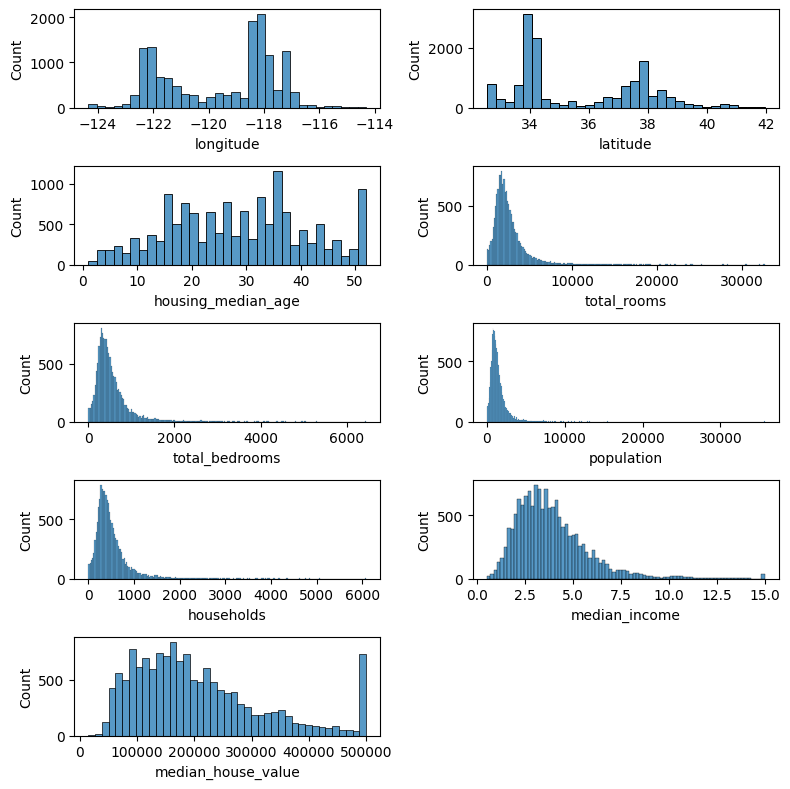

In [13]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (8,8))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(5,2,posisi)
    sns.histplot(df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

Sebagian besar variabel, menunjukkan distribusi yang skewed ke kanan, yang berarti banyaknya nilai-nilai yang rendah dan sedikit nilai yang sangat tinggi (outliers). grafik tersebut juga menunjukkan data tidak terdistribusi normal

##Outliers

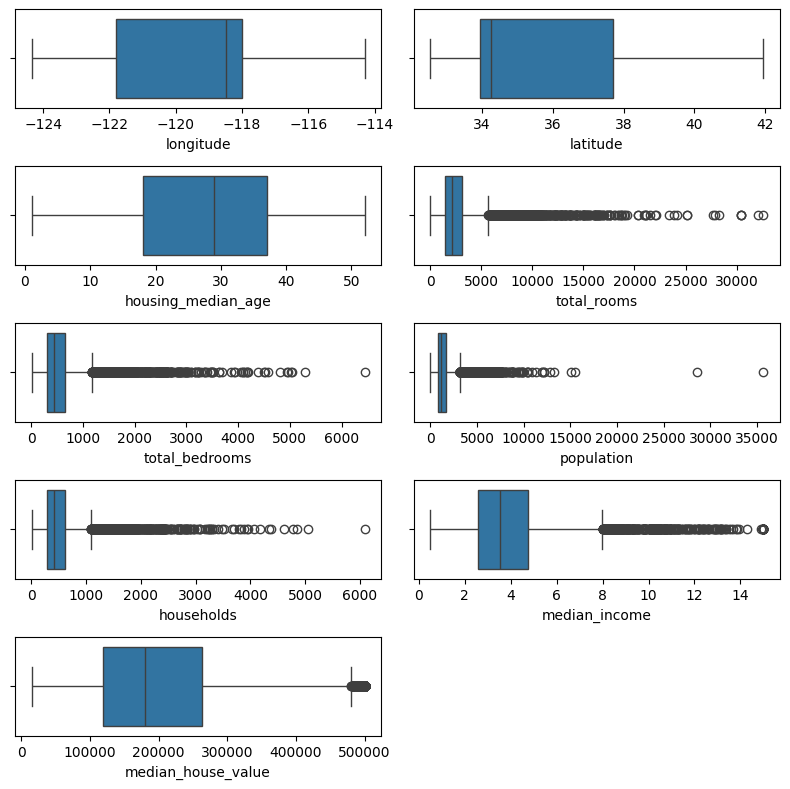

In [14]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (8,8))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(5,2,posisi)
    sns.boxplot(x = df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

Terdapat beberapa outliers pada kolom total_rooms, total_bedrooms, population, households, median_income, dan median_value_house

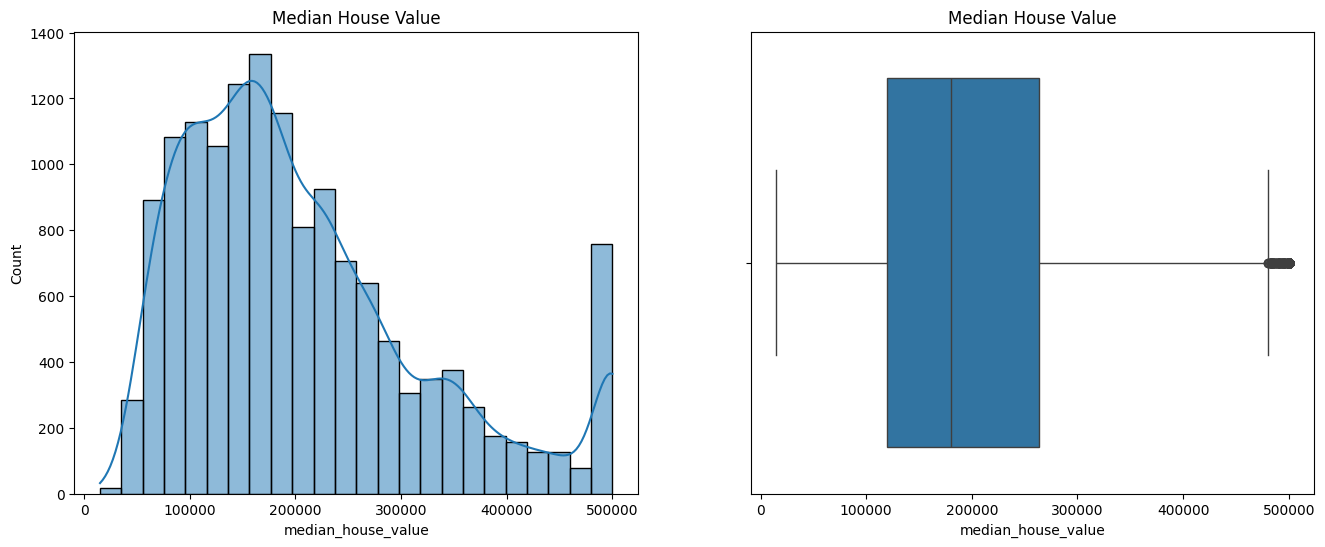

In [60]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.histplot(df['median_house_value'],binwidth=20000,kde=True)
plt.title('Median House Value')

plt.subplot(1,2,2)
sns.boxplot(x= df['median_house_value'])
plt.title('Median House Value')

plt.show()

##Korelasi

<Axes: >

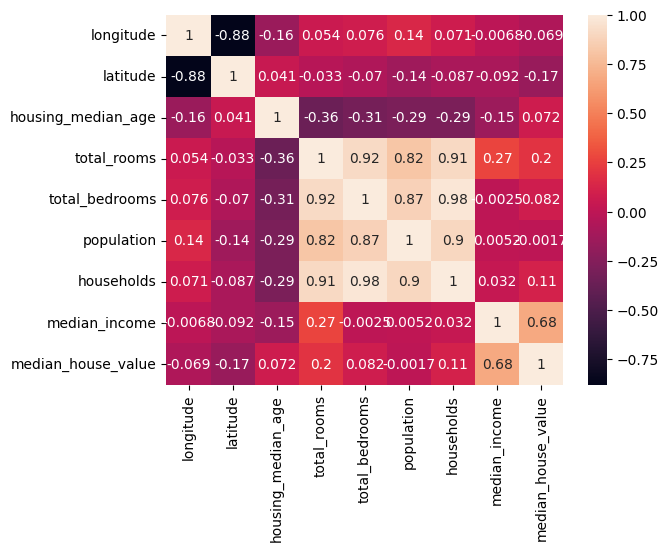

In [16]:
sns.heatmap(numerik.corr(method = 'spearman'), annot = True)

Berdasarkan korelasi tersebut, median_income memiliki korelasi positif yang cukup kuat dengan median_house_value dengan nilai korelasi 0.68 yang menunjukkan bahwa semakin tinggi pendapatan median di suatu area, semakin tinggi juga nilai median rumah di area tersebut.



##Variable Katagorik

In [17]:
df.describe(include = 'object')

,ocean_proximity
count,14448
unique,5
top,<1H OCEAN
freq,6369


Pada variable kategorik, terdapat 5 unique values untuk  kolom ocean_proximity.

#Data Cleaning

##Handling missing value

In [18]:
df1 = df.copy()

karena persentase missing value sangat kecil yakni dibawah 1% maka akan di drop untuk missing value tersebut.

In [19]:
# Membuang baris dengan data null
df1.dropna(inplace=True)
df1.reset_index(drop=True,inplace=True)
df1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0
...,...,...,...,...,...,...,...,...,...,...
14306,-120.06,36.94,19.0,901.0,183.0,700.0,190.0,2.2375,INLAND,64300.0
14307,-121.26,38.27,20.0,1314.0,229.0,712.0,219.0,4.4125,INLAND,144600.0
14308,-120.89,37.48,27.0,1118.0,195.0,647.0,209.0,2.9135,INLAND,159400.0
14309,-117.93,33.62,34.0,2125.0,498.0,1052.0,468.0,5.6315,<1H OCEAN,484600.0


In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14311 entries, 0 to 14310
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14311 non-null  float64
 1   latitude            14311 non-null  float64
 2   housing_median_age  14311 non-null  float64
 3   total_rooms         14311 non-null  float64
 4   total_bedrooms      14311 non-null  float64
 5   population          14311 non-null  float64
 6   households          14311 non-null  float64
 7   median_income       14311 non-null  float64
 8   ocean_proximity     14311 non-null  object 
 9   median_house_value  14311 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.1+ MB


In [21]:
# Jumlah data kosong (NaN) untuk setiap variable
df1.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


##Handling Outliers

In [22]:
#Menentukan batas ambang filter
q1 = np.percentile(df['median_house_value'], 25)
q3 = np.percentile(df['median_house_value'], 75)
iqr = q3-q1
tresh = q3 + 1.5*iqr
tresh

480350.0

In [34]:
#Menyaring data dengan median_house_value di atas batas ambang
df1 = df1[df1['median_house_value'] < tresh]
df1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,avg_rooms,avg_bedrooms
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0,3.0,1.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0,4.0,1.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0,6.0,1.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0,3.0,1.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14305,-117.10,32.73,24.0,2927.0,704.0,2005.0,668.0,2.2375,NEAR OCEAN,102900.0,4.0,1.0
14306,-120.06,36.94,19.0,901.0,183.0,700.0,190.0,2.2375,INLAND,64300.0,5.0,1.0
14307,-121.26,38.27,20.0,1314.0,229.0,712.0,219.0,4.4125,INLAND,144600.0,6.0,1.0
14308,-120.89,37.48,27.0,1118.0,195.0,647.0,209.0,2.9135,INLAND,159400.0,5.0,1.0


dataset difilter dari outliers dengan menerapkan treshold pada q3.

##Penambahan fitur

In [36]:
#Membuat 2 kolom baru
df1['avg_rooms'] = round(df1['total_rooms']/df1['households'])
df1['avg_bedrooms'] = round(df1['total_bedrooms']/df1['households'])
df1

<ipython-input-36-62717ca3f716>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['avg_rooms'] = round(df1['total_rooms']/df1['households'])
<ipython-input-36-62717ca3f716>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['avg_bedrooms'] = round(df1['total_bedrooms']/df1['households'])


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,avg_rooms,avg_bedrooms
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0,3.0,1.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0,4.0,1.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0,6.0,1.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0,3.0,1.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14305,-117.10,32.73,24.0,2927.0,704.0,2005.0,668.0,2.2375,NEAR OCEAN,102900.0,4.0,1.0
14306,-120.06,36.94,19.0,901.0,183.0,700.0,190.0,2.2375,INLAND,64300.0,5.0,1.0
14307,-121.26,38.27,20.0,1314.0,229.0,712.0,219.0,4.4125,INLAND,144600.0,6.0,1.0
14308,-120.89,37.48,27.0,1118.0,195.0,647.0,209.0,2.9135,INLAND,159400.0,5.0,1.0


Pada dataset tersebut, kolom total_rooms dan total_bedrooms yang ada di suatu area sebenarnya kurang begitu penting. Rata-rata banyak kamar dan rata-rata banyak kamar tidur lebih diperlukan. Untuk itu ditambahkan kedua fitur avg_rooms dan avg_bedrooms

#EDA

<Axes: xlabel='longitude', ylabel='latitude'>

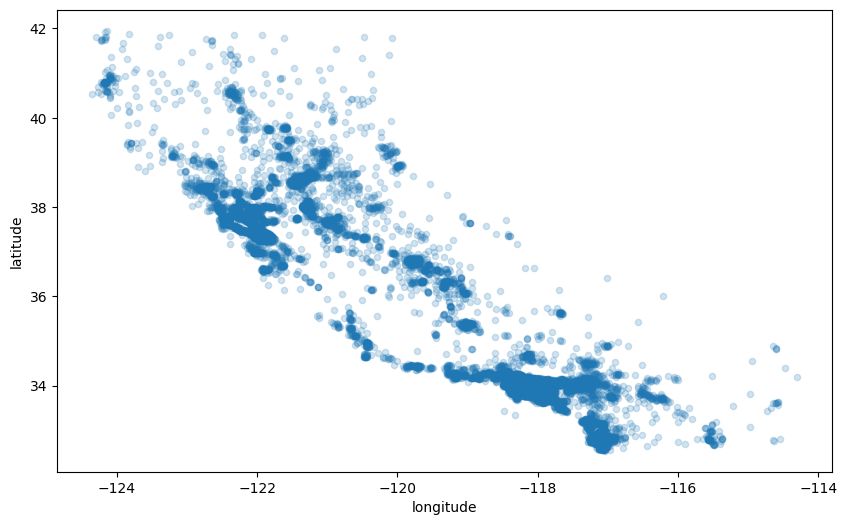

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

df1.plot(x='longitude', y='latitude',kind='scatter',alpha=0.2, figsize=(10,6))

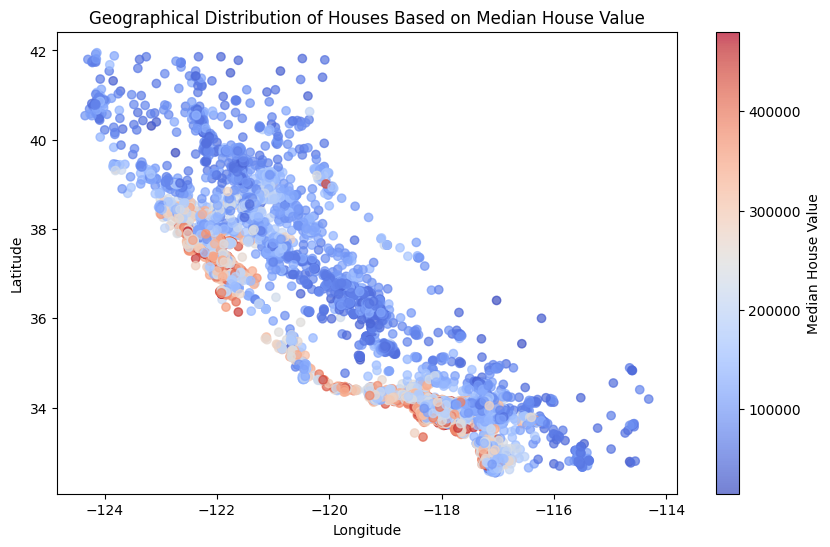

In [63]:
plt.figure(figsize=(10, 6))


scatter = plt.scatter(df1['longitude'], df1['latitude'],
                      c=df1['median_house_value'], cmap='coolwarm', alpha=0.7)


plt.colorbar(scatter, label='Median House Value')

plt.title('Geographical Distribution of Houses Based on Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

Berikut merupakan lokasi perumahan berdasarkan latitude dan longtitude nya di California. Harga rumah akan semakin mahal ketika lokasinya dekat dengan pantai dan rumah dengan harga yang lebih rendah terletak di lokasi yang lebih pedalaman

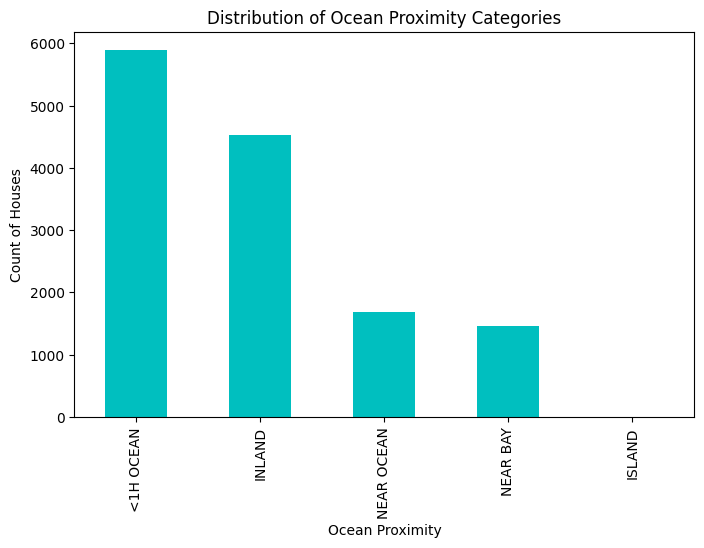

In [39]:
ocean_proximity_counts = df1['ocean_proximity'].value_counts()

plt.figure(figsize=(8, 5))
ocean_proximity_counts.plot(kind='bar', color='c')

plt.title('Distribution of Ocean Proximity Categories')
plt.xlabel('Ocean Proximity')
plt.ylabel('Count of Houses')

plt.show()

Distribusi dari perumahan di California menunjukkan bahwa penduduk paling banyak bertempat tinggal di daerah yang kurang dari 1 jam menuju laut

#Modelling


##Data Splitting

In [40]:
X = df1.drop(['median_house_value'],axis=1)
y = df1['median_house_value']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
)

In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10848, 11), (2712, 11), (10848,), (2712,))

##Encoding

In [43]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer([
    ('encoder_onehot', OneHotEncoder(handle_unknown = 'ignore'), ['ocean_proximity']),
], remainder='passthrough')

##Choose a Benchmark Model

In [44]:
# Define algoritma yang digunakan
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1)
xgb = XGBRegressor(random_state=1)

# Pemodelan dilakukan dalam skala logaritmik, namun kemudian di-inverse kembali untuk interpretasi
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_knn = TransformedTargetRegressor(knn, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)

# Scaling data
scaler = StandardScaler()

# Kandidat algoritma
models = [log_lr, log_knn, log_dt, log_rf, log_xgb]

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

# Mencari algoritma terbaik berdasarkan nilai MAE
for i in models:

    crossval = KFold(n_splits=5, shuffle=True, random_state=1)

    estimator = Pipeline([
        ('preprocessing', transformer),
        ('model', i)
    ])

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=crossval,
        scoring='neg_root_mean_squared_error',
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    nilai_mean_rmse.append(model_cv_rmse.mean())
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=crossval,
        scoring='neg_mean_absolute_error',
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    nilai_mean_mae.append(model_cv_mae.mean())
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=crossval,
        scoring='neg_mean_absolute_percentage_error',
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_mape.append(model_cv_mape)
    nilai_mean_mape.append(model_cv_mape.mean())
    nilai_std_mape.append(model_cv_mape.std())

[-60454.53242654 -63882.01841252 -64567.41347751 -64281.60422589
 -61670.31268945] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-42569.40253828 -44478.44035204 -44114.66665624 -41669.0468028
 -42900.17349462] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-0.24052426 -0.24408017 -0.24944994 -0.2426091  -0.25123325] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-92100.9079493  -91775.08669749 -91698.04058088 -88258.52945042
 -90177.38683726] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=KNeighborsRegressor())
[-71893.76775606 -70837.03892435 -71796.0193053  -68199.12616807
 -69958.12738535] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
 

In [45]:
# Evaluasi hasil dari 5 kandidat algoritma yang digunakan
pd.DataFrame({
    'Model': ['Linear Regression', 'KNN Regressor', 'DecisionTree Regressor', 'RandomForest Regressor', 'XGBoost Regressor'],
    'Mean_RMSE': nilai_mean_rmse,
    'Std_RMSE': nilai_std_rmse,
    'Mean_MAE': nilai_mean_mae,
    'Std_MAE': nilai_std_mae,
    'Mean_MAPE': nilai_mean_mape,
    'Std_MAPE': nilai_std_mape
})

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
0,Linear Regression,-62971.176246,1619.911748,-43146.345969,1028.396600,-0.245579,0.004088
1,KNN Regressor,-90801.990303,1435.014449,-70536.815908,1365.043523,-0.457776,0.011185
2,DecisionTree Regressor,-63090.147131,2138.787276,-42750.883736,1272.947541,-0.247918,0.012113
3,RandomForest Regressor,-45635.557733,1334.946927,-30346.599171,807.869817,-0.171699,0.008469
4,XGBoost Regressor,-44177.434460,1109.546835,-29152.204139,508.210475,-0.166664,0.007917


Terdapat lima algoritma yang dibandingkan berdasarkan beberapa metrik evaluasi, yaitu Mean RMSE, Std RMSE, Mean MAE, Std MAE, Mean MAPE, dan Std MAPE.

Berdasarkan hasil evaluasi, XGBoost Regressor menunjukkan performa terbaik dalam hal akurasi prediksi (RMSE, MAE, MAPE) dan konsistensi prediksi (Standar Deviasi yang lebih rendah). Selanjutnya dilanjutkan dengan RandomForest Regressor juga menunjukkan performa yang cukup baik, dengan nilai yang relatif lebih rendah dibandingkan Linear Regression, DecisionTree, dan KNN Regressor.

1. RMSE : Nilai rataan akar kuadrat dari error
2. MAE : Rataan nilai absolut dari error
3. MAPE : Rataan persentase error yang dihasilkan oleh model regresi
4. R-squared : Untuk mengetahui seberapa baik model dapat merepresentasikan varians keseluruhan data.

In [46]:
# Benchmark 2 model terbaik
models = {
    'RandomForest': RandomForestRegressor(random_state=1),
    'XGB': XGBRegressor(random_state=1)

}

score_rmse = []
score_mae = []
score_mape = []

# Prediksi pada test set
for i in models:

    model = Pipeline([
        ('preprocessing', transformer),
        ('model', models[i])
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    score_mae.append(mean_absolute_error(y_test, y_pred))
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))

score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=models.keys())
score_before_tuning

,RMSE,MAE,MAPE
RandomForest,45623.284212,31296.245907,0.187428
XGB,43065.563032,29402.384840,0.172354


Selanjutnya dilakukan prediksi pada test set dengan menggunakan model XGBoost dan Random Forest. Prediksi test tersebut menghasilkan performa XGBoost yang terbaik diantara kedua model yang menunjukkan bahwa XGBoost mampu memprediksi nilai target dengan tingkat error yang lebih kecil secara keseluruhan.

XGBoost memiliki MAE lebih rendah dibandingkan dengan Random Forest, yang menandakan bahwa rata-rata error absolut antara prediksi dan nilai aktual lebih kecil. MAPE 0.1723 pada XGBoost menandakan error rata-rata dari model XGBoost adalah sekitar 17.23% dari nilai sebenarnya, yang sedikit lebih baik dibandingkan Random Forest.

##Hyperparameter Tuning

XGBoost memiliki performa yang lebih baik dari random forest sehingga akan dilakukan Hyperparameter Tuning pada XGBoost untuk meningkatkan performa model.

XGBoost adalah salah satu algoritma machine learning yang termasuk dalam kategori ensemble learning, lebih spesifiknya dalam keluarga gradient boosting. XGBoost dirancang untuk meningkatkan kinerja prediksi dengan cara menggabungkan banyak weak learners (biasanya berupa pohon keputusan) secara iteratif. XGBoost sangat efisien dalam menghasilkan prediksi dengan error yang lebih rendah karena proses iteratif yang memperbaiki kesalahan secara bertahap. Dengan fitur regularisasi dan teknik optimasinya, XGBoost sering kali menjadi pilihan utama dalam kompetisi machine learning dan digunakan di berbagai aplikasi bisnis untuk menyelesaikan masalah prediksi.

In [47]:
# Kedalaman pohon
max_depth = list(np.arange(1, 11))

# Learning rate
learning_rate = list(np.arange(1, 100)/100)

# Jumlah pohon
n_estimators = list(np.arange(100, 201))

# Jumlah baris tiap pohon (% dari total baris train set)
subsample = list(np.arange(2, 10)/10)

# Gamma (min_impurity_decrease)
gamma = list(np.arange(1, 11)) # Semakin besar nilainya, semakin konservatif/simpel modelnya

# Jumlah feature yang digunakan untuk tiap pohon (% dari total kolom train set)
colsample_bytree = list(np.arange(1, 10)/10)

# Alpha (regularization)
reg_alpha = list(np.logspace(-3, 1, 10)) # Semakin besar nilainya, semakin konservatif/simpel modelnya


# Hyperparam space XGboost
hyperparam_space_xgb = {
    'model__max_depth': max_depth,
    'model__learning_rate': learning_rate,
    'model__n_estimators': n_estimators,
    'model__subsample': subsample,
    'model__gamma': gamma,
    'model__colsample_bytree': colsample_bytree,
    'model__reg_alpha': reg_alpha
}

In [48]:
# Benchmark model dengan hyperparameter tuning
xgb = XGBRegressor(random_state=1, verbosity=0)

# Membuat algorithm chains
estimator_xgb = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', xgb)
        ])

crossval = KFold(n_splits=5, shuffle=True, random_state=1)

# Hyperparameter tuning
random_xgb = RandomizedSearchCV(
    estimator_xgb,
    param_distributions = hyperparam_space_xgb,
    n_iter = 50,
    cv = crossval,
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    n_jobs = -1,
    refit = 'neg_root_mean_squared_error', # Hanya bisa memilih salah stau metric untuk optimisasi
    random_state = 1
)

In [49]:
# Fitting data training untuk mencari parameter terbaik
random_xgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('encoder_onehot',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['ocean_proximity'])])),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsampl...
                                                             0.007742636826811269,
                                                             0.021544346900318832,
                                                             0.05994842503189409,
                                                             0.1668100537200059,
                                                             0.46415888336127775,
                                                             1.2915496650148828,
                                                             3.593813663804626,
                                                             10.0],
                                        'model__subsample': [0.2, 0.3, 0.4, 0.5,
                                                             0.6, 0.7, 0.8,
                                                             0.9]},
                   random_state=1, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

In [50]:
# Melihat hasil tuning dalam bentuk dataframe. Diurutkan berdasarkan RMSE, MAE & MAPE
pd.DataFrame(random_xgb.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
7,1.581590,0.147192,0.033029,0.006388,0.9,0.059948,119,8,0.05,5,...,490.230382,1,-0.168228,-0.171171,-0.188122,-0.172085,-0.178934,-0.175708,0.007130,1
20,0.349875,0.046751,0.019560,0.001468,0.9,0.007743,143,4,0.38,6,...,378.981982,2,-0.180684,-0.181110,-0.195857,-0.184883,-0.190566,-0.186620,0.005822,2
17,0.758376,0.122157,0.029034,0.008043,0.6,0.001000,190,5,0.04,9,...,514.314427,4,-0.183561,-0.188479,-0.200406,-0.187419,-0.191758,-0.190325,0.005679,3
8,1.122235,0.147275,0.054649,0.006837,0.7,0.021544,182,6,0.31,2,...,589.371518,3,-0.186630,-0.184538,-0.201525,-0.195684,-0.194312,-0.192538,0.006208,4
3,0.842176,0.019420,0.036122,0.001887,0.5,0.021544,166,8,0.10,9,...,273.083347,7,-0.195493,-0.192385,-0.208136,-0.196354,-0.200831,-0.198640,0.005463,7


In [51]:
# Cek skor dan params terbaik
print('XGBoost')
print('Best_score:', random_xgb.best_score_)
print('Best_params:', random_xgb.best_params_)

XGBoost
Best_score: -43250.16283300784
Best_params: {'model__subsample': 0.9, 'model__reg_alpha': 0.05994842503189409, 'model__n_estimators': 119, 'model__max_depth': 8, 'model__learning_rate': 0.05, 'model__gamma': 5, 'model__colsample_bytree': 0.8}


##Predict to Test Set with the Tuned Model

In [52]:
# Model XGBoost
model = {'XGB': XGBRegressor(random_state=1)}

# Define model terhadap estimator terbaik
xgb_tuning = random_xgb.best_estimator_

# Fitting model
xgb_tuning.fit(X_train, y_train)

# Predict test set
y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_xgb_tuning = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

score_after_tuning = pd.DataFrame({'RMSE': rmse_xgb_tuning, 'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning}, index=model.keys())
score_after_tuning

,RMSE,MAE,MAPE
XGB,42734.207115,29164.761723,0.171719


##Performance comparison

In [53]:
pd.DataFrame(score_before_tuning.loc['XGB']).T

,RMSE,MAE,MAPE
XGB,43065.563032,29402.38484,0.172354


In [54]:
# Setelah hyperparameter tuning
score_after_tuning

,RMSE,MAE,MAPE
XGB,42734.207115,29164.761723,0.171719


Model mengalami peningkatan performa yang dilihat dari nilai RMSE, MAE & MAPE dengan dilakukannya hyperparameter tuning.

RMSE, MAE & MAPE sebelum tuning: 43065.56, 29402.38, 0.172

RMSE, MAE & MAPE setelah tuning: 42734.20, 29164.76, 0.171

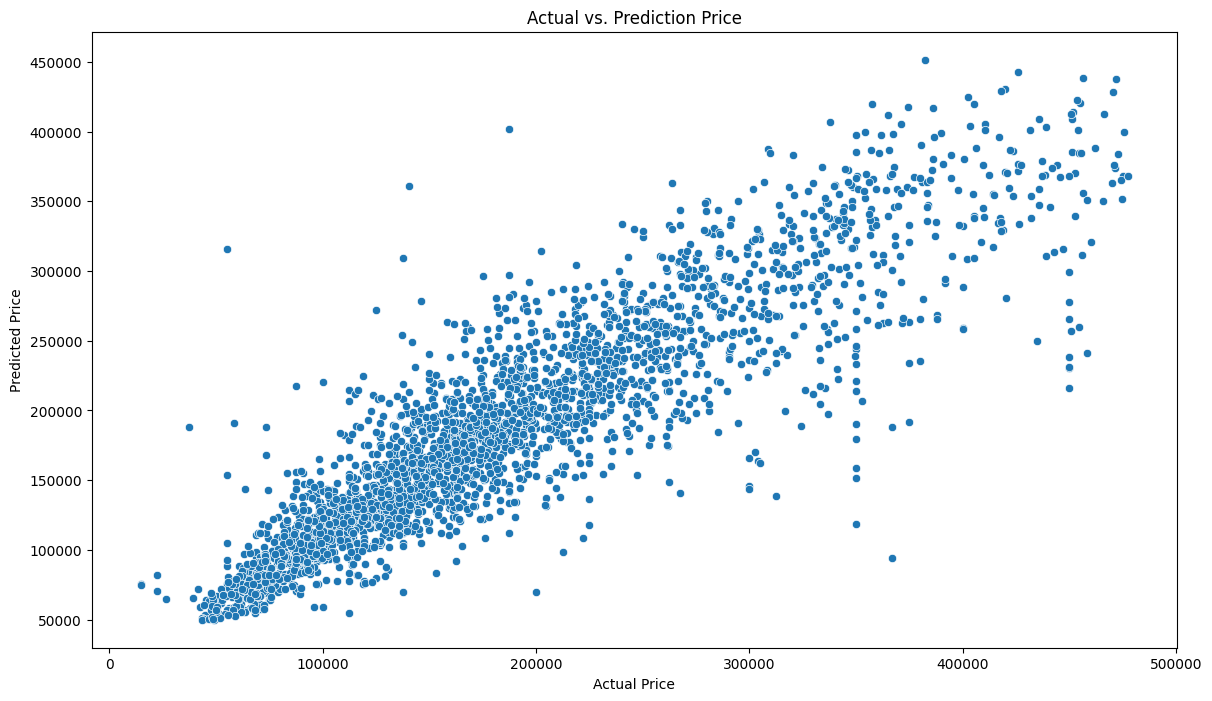

In [55]:
plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=y_test, y=y_pred_xgb_tuning).set(title='Actual vs. Prediction Price',
                                               xlabel='Actual Price',
                                               ylabel='Predicted Price');

Berdasarkan grafik tersebut terlihat bahwa actual price dan predicted price terlihat cukup bagus karena membentuk garis diagonal yang naik dari kiri bawah ke kanan atas. Ini mengindikasikan adanya korelasi positif antara harga aktual dan harga yang diprediksi. Artinya, ketika harga aktual meningkat, harga yang diprediksi juga cenderung meningkat.
Namun, titik-titik tidak sepenuhnya berada di dalam garis yang lurus sempurna yang menandakan kesalahan prediksi model yang masih wajar dilihat dari nilai MAPE yang kecil.

**Future Importances**

In [56]:
transformer.transformers_

[('encoder_onehot',
  OneHotEncoder(handle_unknown='ignore'),
  ['ocean_proximity']),
 ('remainder',
  FunctionTransformer(accept_sparse=True, check_inverse=False,
                      feature_names_out='one-to-one'),
  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10])]

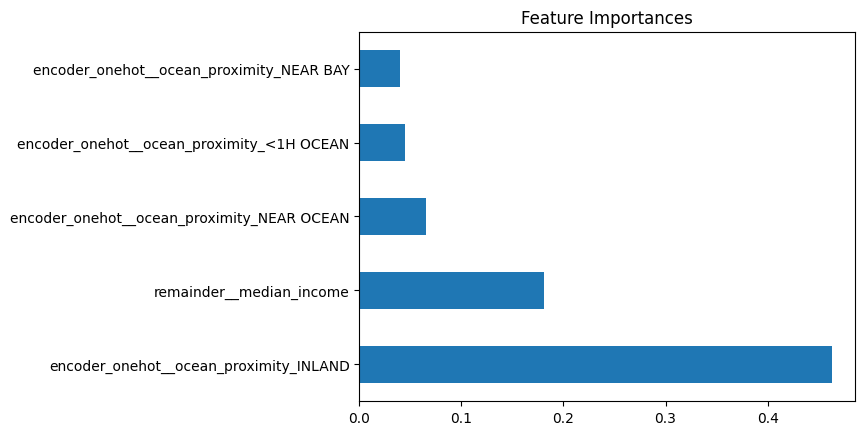

In [59]:
# Plot feature importances
feature_imp = pd.Series(xgb_tuning['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head()
feature_imp.plot(kind='barh', title='Feature Importances');

#Conclusion

Diantara 5 model regresi, XGBoost merupakan algoritma pemodelan yang paling baik dalam memprediksi nilai median rumah di California dari dataset.

Fitur yang paling berpengaruh terhadap median_house_value adalah ocean_proximity dan median_income. Hal tersebut masuk akal dimana harga rumah akan meningkat ketika berada di kawasan yang elit dan dalam konteks ini adalah rumah yang berada di dekat laut. Dan penghasilan seseorang dalam suatu wilayah tentunya juga akan mempengaruhi penentuan harga rumah di wilayah tersebut.

Metrik evaluasi yang digunakan pada model adalah nilai RMSE, MAE & MAPE. Jika ditinjau dari nilai MAPE yang dihasilkan oleh model setelah dilakukan hyperparameter tuning, yaitu sebesar ~17.1%.

#Recommendation

Dengan menggunakan model XGBoost yang telah di-tuning, prediksi lebih akurat dapat mendukung pengambilan keputusan yang lebih baik, seperti dalam menentukan harga, atau mengalokasikan sumber daya yang tepat. Menggunakan metode tuning yang lebih canggih seperti Grid Search atau Random Search dengan ruang hyperparameter yang lebih luas mungkin bisa memberikan peningkatan performa yang lebih signifikan.

Data set perlu diupdate lagi untuk menghasilkan hasil yang relavan dengan kondisi tahun ini karena dataset diambil pada tahun 1990

Perlu ditambahkan fitur yang berhubungan dengan harga rumah seperti luas tanah dan bangunan serta fasilitasnya

